This notebook is a collection of code and personal notes following Chapter 3: Classification of *Hands-On Machine Learning with SciKit-Learn & TensorFlow* by Aurelien Geron 1st Ed.

In [15]:
#Importing MNIST dataset with SciKit-Learn's built in function
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

The MNIST data set consists of 70,000 handwritten digits. The data is in the form of 28x28 pixel images whose intensities are in the range (0-255). The data is represented as a 1D vector with 728 values representing the intensities of each pixel. The original image can be recovered by reshaping the vector into a 28x28 matrix. The labels are an integer value in the range 0-9.

In [26]:
print('Shape of data: ',X.shape,',', 'Shape of labels: ',y.shape)

Shape of data:  (70000, 784) , Shape of labels:  (70000,)


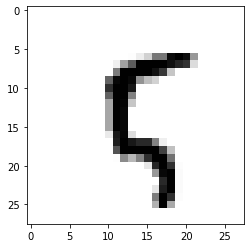

In [27]:
import matplotlib.pyplot as plt
example_digit = X[100]
example_digit_image = example_digit.reshape(28,28)

plt.imshow(example_digit_image, cmap = matplotlib.cm.binary, interpolation='nearest')

Now we can split the data into train and test sets as well as shuffle the data so that their is no ordering bias.

In [28]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [29]:
import numpy as np
shuffle_indices = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_indices], y_train[shuffle_indices]

Now we can train the models of our choosing on the data. In this example we use one of SciKit-Learn's built-in models: a Stochastic Gradient Descent Classifier. By default it fits a Support Vector Machine using Sotchastic Gradient Descent as the learning routine.

In [31]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=99)
sgd_clf.fit(X_train, y_train)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=99, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

SciKit-Learn models have a predict function that can be used to make predicitions on data points conveniently. We can train our model to be a Binary Classifier by creating a new training and test set with labels set to True for some particular digit, say 6. This requires us to create new train and test set with labels of True for digits abelled 6 and False for digits not labelled 6.

In [39]:
# This returns a tuple of Booleans, True when the value of the label is 6 and False otherwise
# Note that the labels are strings and not integers
y_train_6 = (y_train == '6')
y_test_6 = (y_test == '6')

In [40]:
sgd_clf_binary = SGDClassifier(random_state=99)
sgd_clf_binary.fit(X_train, y_train_6)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=99, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

We can now use the trained model to classify a digit. Recall that ```example_digit``` is labelled as a 5. Thus, the model accurately classifies it as not a 6.

In [42]:
sgd_clf_binary.predict([example_digit])

array([False])

Now that we have a trained model that can make predictions we need a way to measure how well it performs. Performance measures for classifiers are a little more complicated than for regressors. A good baseline is using K-Fold Cross Validation to determine prediction accuracy (number of test labels accuractely predicted divided by total number of data points in the test set). This can be misleading as it is possible, and common, that datasets are skewed.. That is, some classes could have unequal representation and thus a classifier trained to predict one class could obtain a very high accuracy while failing to accurately classify any of the smaller classes.

In [49]:
#StratifiedKFold creates folds that contain a representative ratio of each class
from sklearn.model_selection import StratifiedKFold
#Clone creates a copy of an sklearn model
from sklearn.base import clone
#Implementation of K-Fold Cross Validation
def k_fold_crossval(model, X_train, X_test, y_train, y_test, n_splits):
    skfolds = StratifiedKFold(n_splits=n_splits, random_state=99)
    for train_index, test_index in skfolds.split(X_train, y_train):
        model_clone = clone(model)
        X_train_fold = X_train[train_index]
        y_train_fold = y_train[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train[test_index]

        model_clone.fit(X_train_fold, y_train_fold)
        y_pred = model_clone.predict(X_test_fold)
        number_correct = sum(y_pred == y_test_fold)
        return number_correct/len(y_pred)

In [50]:
k_fold_crossval(sgd_clf_binary, X_train, X_test, y_train_6, y_test_6, 3)

0.9780510974451277

A better way to evaluate the performance of a classifier is to compute the *confusion matrix*. The confusion matrix is a matrix whose rows are classes and columns are predicted classes. Thiskeeps track of how many times Class A was mistakenly classified as Class B.  This value would be in row 'A' and column 'B'. A perfect classifier would have only true positives and true negatives. We first need a set of predictions to analyze. For this, we can use the ```cross_val_predict``` function which returns a list of predictions made on each of k folds. It is important to note that it is done this way so that the predictions are made on data the model didn't see during training. The text refers to these as 'clean' predictions.

In [52]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf_binary, X_train, y_train_6, cv=3)

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_6, y_train_pred)

array([[53359,   723],
       [  594,  5324]])

Two more concise metrics for binary classification are *precision* and *recall*. Precision, $P$ is given by
$$ P = \frac{TP}{TP+FP}$$ 
This is the accuracy of positive predictions. Recall, $R$, is given by
$$ R = \frac{TP}{TP+FN}$$
This is the ratio of positive instances of a particular class that are correctly classified. Scikit-Learn provides functions for computing these two quantities.

In [56]:
from sklearn.metrics import recall_score, precision_score
P = precision_score(y_train_6, y_train_pred)
R = recall_score(y_train_6, y_train_pred)
print('Precision: ', P)
print('Recall: ', R)

Precision:  0.8804365801223747
Recall:  0.8996282527881041


These two metrics can be combined to produce the $F_1$ score of a binary classifier. The $F_1$ score is given by
$$ F_1 = \frac{2}{\frac{1}{P}+\frac{1}{R}} = \frac{TP}{TP+\frac{FN+FP}{2}}$$
Note that this metric favors classifiers with similar precision and recall which is not always desirable. Moreover, precision and recall are inversely related. this is called the Precision/Recall Tradeoff. The Precision/Recall Tradeoff stems from the decision boundary structure of most classification algorithms: A score is computed on a data point and then the value of the score is compared to some decision boundary to make the prediction.

In [57]:
from sklearn.metrics import f1_score
f1_score(y_train_6, y_train_pred)

0.8899289594651066

We can fine tune the behavior of our algorithms to favor precision or recall by fine-tuning the decision boundary value of our model. Scikit-Learn model objects have a built in ```decision_function``` method which returns the value of the decision function when predicting on the data points passed as an argument. Below is an example of accessing the decision value of our model for a given instance as well as how altering the threshold of the model could alter predictions.

In [63]:
decision_score = sgd_clf_binary.decision_function([example_digit])
threshold_1 = 0
threshold_2 = -20000
decision_1 = (decision_score > threshold_1)
decision_2 = (decision_score > threshold_2)
print('First Decision: ', decision_1, 'Second Decision: ', decision_2)

First Decision:  [False] Second Decision:  [ True]


In order to figure out which decision boundary meets our preciison/recall needs we first need a list of decision scored for each element in our training data. We can use the built-in ```cross_val_predict``` function with the ```method='decision_function'``` keyword argument to get a list of such decision scores.

In [64]:
decision_scores = cross_val_predict(sgd_clf_binary, X_train, y_train_6, cv=3, method='decision_function')

Now that we have the decision scores we can calculate precision/recall for a range of decision boundary values using the built-in ```precision_recall_curve``` function and plot them.

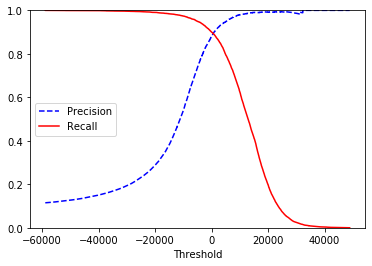

In [66]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_6, decision_scores)
def plot_precision_recall_curve(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='Precision')
    plt.plot(thresholds, recalls[:-1], "r", label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])
    plt.show()

plot_precision_recall_curve(precisions, recalls, thresholds)

An alternative to the Precision/Recall curve for binary classifiers is the *receiver operating characteristic* (ROC) curve. This curve is a plot of the true positive rate (also known as recall) against the false positive rate. We can use another built-in function to calculate the ROC curve and plot it. 

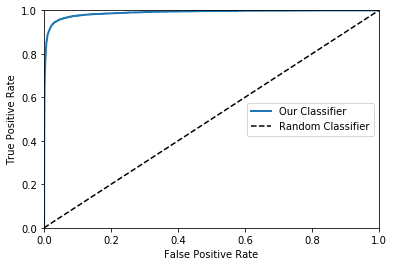

In [67]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_6, decision_scores)
def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr, linewidth=2, label="Our Classifier")
    plt.plot([0,1],[0,1], 'k--', label='Random Classifier')
    plt.axis([0,1,0,1])
    plt.legend(loc='center right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

plot_roc(fpr,tpr)

Another way to compare classifiers is to use the *Area Under the Curve* (AUC) of each classifier's ROC curve. A perfect classifier will have AUC ROC equal to 1 and a completely random classifier will have an AUC ROC of .5. Scikit-Learn has a built in function for retrivieng AUC ROC

In [70]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_train_6, decision_scores)
auc

0.9890494850053028

Although both the Precision/Recall Curve and ROC Curve can be used to evaluate Binary Classifiers, they are each better suited to certain problems. In the case of the PR curve, it should be used when the positive class is rare or when we care more about false positves than false negatives. The ROC curve should be used otherwise. In our example, the AUC ROC is very high but this is beause the positive class '6' is rare compared to the negative class (all other integers 0-9).

So far, we have considered only Binary Classifiers. That is, classifiers which predict whether a data point belongs to a single target class or not. A more general problem is to classify data points into one of several classes. Some algorithms, like Naive Bayes and Random Forests, are capable of handling multi-class classification out of the box. Other algorithms, like Linear classifiers or Support Vector Machines can not do multi-class classification due to their formulation. Algorithms which cannot do multi-class classification by default can be bootstrapped to do so in one of two ways: One-vs-One (OVO) or One-vs-All (OVA) classification. In the OVO scheme, one classifier is trained for each pair of classes on data consisitng of only those two classes. Then, to make predicitions the data point is run through all of those classifiers and the class that wins the most is selected. Note that for data with $N$ classes this requires training $N(N-1)/2$ classifiers. In the OVA scheme, a binary classifier is trained for each class. A new data point is then run through each binary classifier and the class with the highest decision score is selected. The primary consideration in choosing one of these schemes is how efficiently a particular algorithm (which is not capable of multi-class classification on its own) learns on large datasets. In the case of the Support Vector Machine, it does not train effeciently on large datasets and thus it is favorable to train a large amount of classifiers on small datatsets (OVO) rather than few classifiers on larger datasets (OVA). Scikit-Learn detects when you use a binary classifier on multi-class data and employs a default strategy (depending on the model selected) to train it on the multi-class data. We can see that the original Support Vector Machine we trained ```sgd_clf``` was adapted to multi-class via the OVA by asking for its ```decision_function``` values on our  ```example_digit```.

In [71]:
sgd_clf.decision_function([example_digit])

array([[-23548.14988493, -23617.30455319,   -887.48635719,
         -5179.41443829,  -7872.19720354,    384.08872767,
        -12255.25005121, -17813.61275082,   -828.92159337,
          -971.76327682]])

We can force Scikit-Learn to use either OVO or OVA startegies by creating an instance of the ```OneVsOneClassifier``` or ```OneVsRestClassifier``` classes with our model as the argument. As an example of a model that supports multi-class classification we can train a Random Forest on our data and ask for its probability predictions via ```predict_proba``` (analogous to ```decision_function``` values) on our ```example_digit```.

In [72]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=99)
forest_clf.fit(X_train, y_train)
forest_clf.predict_proba([example_digit])

/home/gerardo/Desktop/Projects/ML/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([[0. , 0. , 0. , 0. , 0.2, 0.8, 0. , 0. , 0. , 0. ]])

Now we can evaluate the performance of our classifiers via cross validation.

In [74]:
from sklearn.model_selection import cross_val_score
sgd_clf_perf = cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')
forest_clf_perf = cross_val_score(forest_clf, X_train, y_train, cv=3, scoring='accuracy')
print('SGDClassifier Accuracy: ', sgd_clf_perf)
print('RandomForestClassifier Accuracy: ,', forest_clf_perf)

SGDClassifier Accuracy:  [0.88662268 0.86949347 0.86567985]
RandomForestClassifier Accuracy: , [0.94146171 0.94314716 0.94034105]


Now that we have a trained some multi-class models we can pick one and try to improve it. A good way to improve a classification model is to try and figure out what kind of errors it makes. For this, we can create a confusion matrix. I am going to do this for the RandomForestClassifier I just trained.

[]

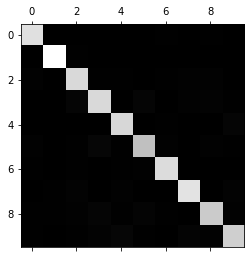

In [75]:
forest_clf_preds = cross_val_predict(forest_clf, X_train, y_train, cv=3)
forest_clf_confusion_matrix = confusion_matrix(y_train, forest_clf_preds)
plt.matshow(forest_clf_confusion_matrix,  cmap=plt.cm.gray)
plt.plot()

This matrix alone does not enlighten us very much. We should focus on the error rates rather than the absolute errors. To do this we can scale the entries in the matrix by the total number of predictions as well as get rid of the diagonals (correct predicitons)

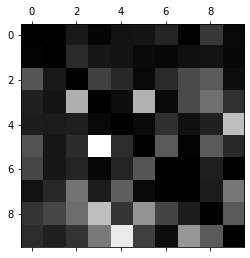

In [76]:
row_sums = forest_clf_confusion_matrix.sum(axis=1, keepdims=True)
normalized_matrix = forest_clf_confusion_matrix / row_sums
np.fill_diagonal(normalized_matrix, 0)
plt.matshow(normalized_matrix, cmap=plt.cm.gray)
plt.show()


This shows us that often 9s are confused for 4s and 5s are confused for 3s. With this information we can iterate on our feature engineering process as well as preprocessing to build a better model.

There are more general classification problems in which the required output is multiple labels. This is called Multilabel Classification. A simple example is below, in which we train a classifier to determine whether a given data point is 'large' and/or 'odd'. First we build a new data set from our original MNIST data set and then we train a K-Nearest Neighbors model on the data.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 = 1)
# This function stacks two 1D arrays as columns into a 2D array
y_train_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train_multilabel)
knn_clf.predict([example_digit])

An example of a performance metric for a multilabel classifier would be to calculate the $F_1$ score for each label and taking the average. Multilabel classification performance measures vary by project and can be adapted from the performance measures discussed earlier.

An even more general classification task would be one in which multiple labels are required as an output where each label can come from multiple (more than 2) classes. This is called Multioutput Classification. We can see an example of this with the MNIST dataset. Let us artifically add some `noise` to the dataset and try to build a classifier that takes as input a `noisy` data point and returns a `clean` version of it. To set this up as a multioutput classification task we make the original images the labels and the noisy images the data points. In this way, the classifier is learning to classify each pixel into one of 0-255 intensity values.

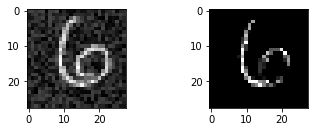

In [88]:
noise = np.random.randint(0,100, (len(X_train),784))
X_train_noisy = X_train + noise
noise = np.random.randint(0,100, (len(X_test), 784))
X_test_noisy = X_test + noise
y_train_noisy = X_train
y_test_noisy = X_test

knn_denoiser = KNeighborsClassifier()
knn_denoiser.fit(X_train_noisy, y_train_noisy)
example_noisy_image = X_test_noisy[100]
clean_image = knn_denoiser.predict([example_noisy_image])

fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(example_noisy_image.reshape(28,28), cmap=plt.cm.gray)
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(clean_image.reshape(28,28), cmap=plt.cm.gray)
